In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
plt.style.use('Solarize_Light2')
from astropy import units as u
import astropy.coordinates as coord
from mpl_toolkits import mplot3d
from sklearn.datasets import make_blobs
import seaborn as sns
import hdbscan


mpl.rcParams['figure.dpi'] = 150


In [4]:
blobs, labels = make_blobs(n_samples=2000, n_features=10) # 10 features
pd.DataFrame(blobs).head() # show the first 5 rows

clusterer = hdbscan.HDBSCAN()





In [5]:
clusterer.fit(blobs) # do the clustering algorithm

#clusterer stores the results of the clusters in the labels_ attribute

clusterer.labels_ # show the labels of the clusters
# This gives an array of integers, where each integer is the cluster number of the corresponding row in the input data

cluster_amount = clusterer.labels_.max() +1 # number of clusters

cluster_amount
#data samples that are not assigned to a cluster get label -1   



3

In [6]:
membership_score = clusterer.probabilities_ # membership score of each data point to the cluster it is assigned to ranging from 0 to 1. 
# A score of 0.0 represents a sample that is not in the cluster at all (all noise points will get this score)
# while a score of 1.0 represents a sample that is at the heart of the cluster (note that this is not the spatial centroid notion of core).

membership_score

array([0.96527588, 0.70850244, 0.74881507, ..., 0.9983924 , 0.85458271,
       0.47191287])

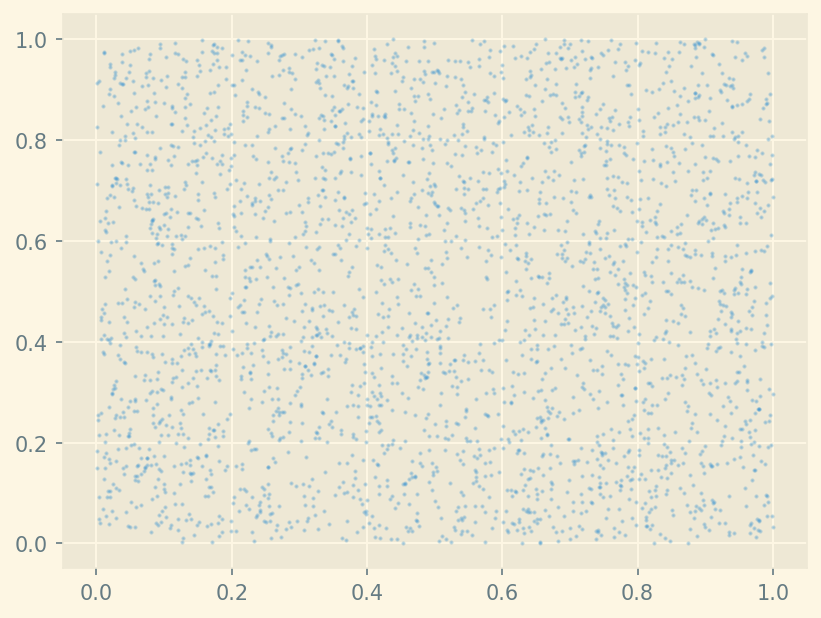

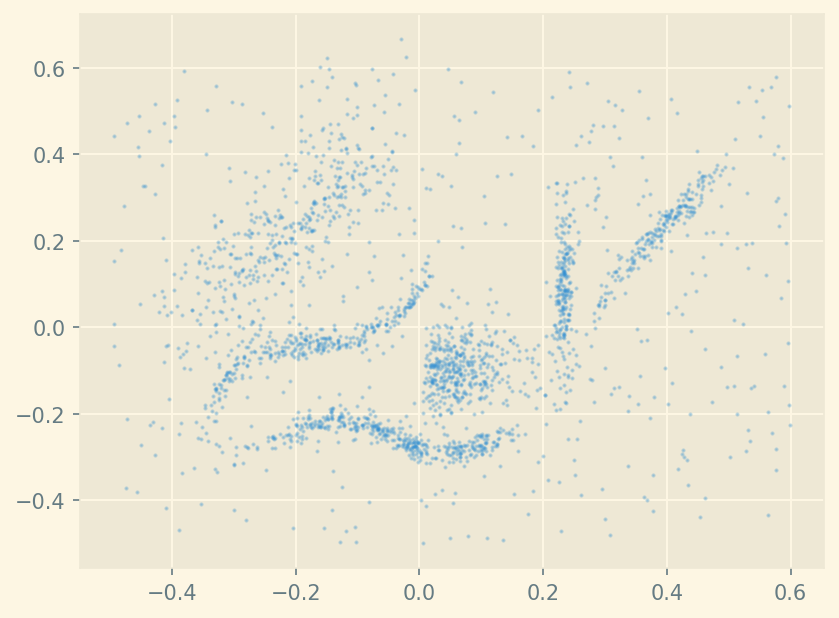

In [7]:
#//generate 3000 random datapoints in 2d

data = np.load('Data\\clusterable_data.npy')
randomdata = np.random.rand(3000,2)
plt.plot(randomdata[:,0], randomdata[:,1], 'o', markersize=1, alpha=0.25, linewidth = 0)
plt.show()

plt.plot(*data.T, 'o', markersize=1, alpha=0.25, linewidth = 0)
plt.show()


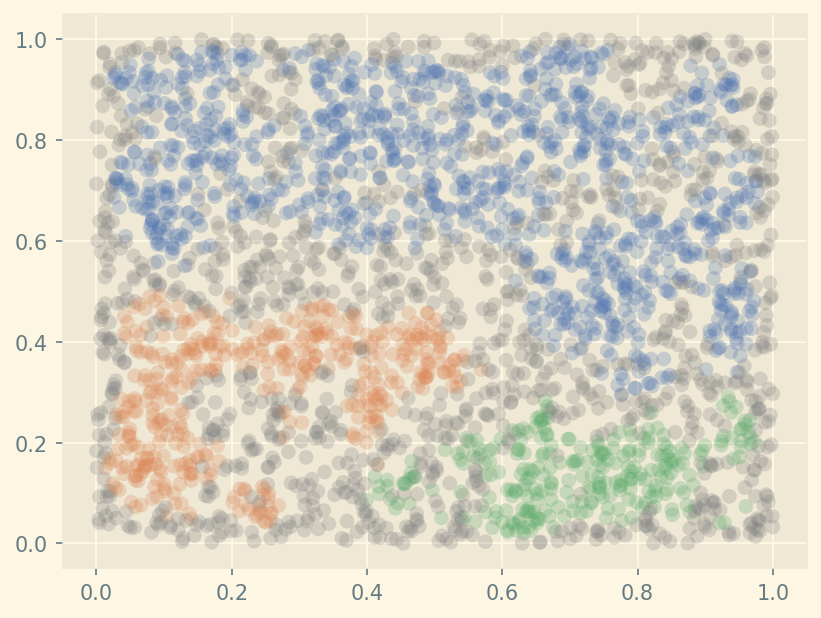

In [8]:

randclusterer = hdbscan.HDBSCAN(min_cluster_size=30).fit(randomdata)
color_palette = sns.color_palette('deep', 77)

cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in randclusterer.labels_]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, randclusterer.probabilities_)]

plt.scatter(randomdata[:,0], randomdata[:,1], s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)



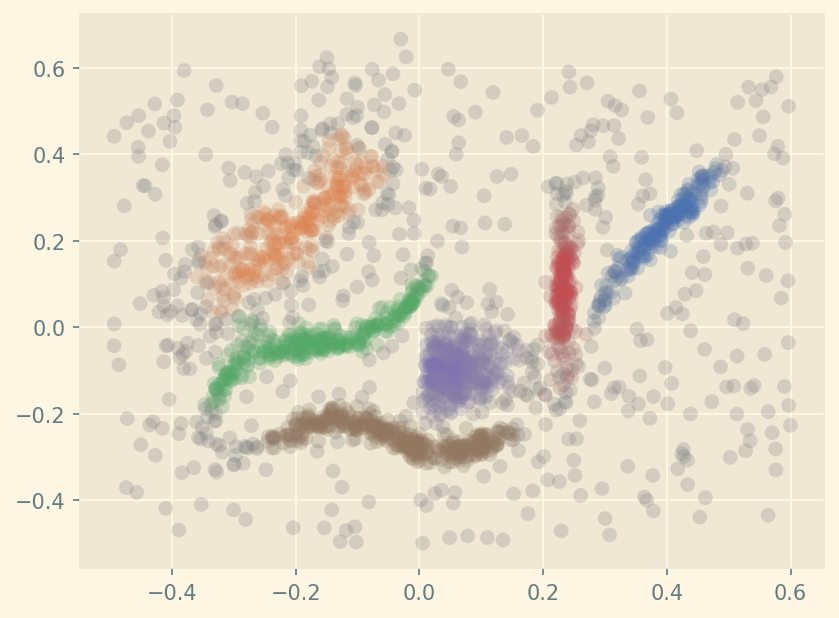

In [9]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

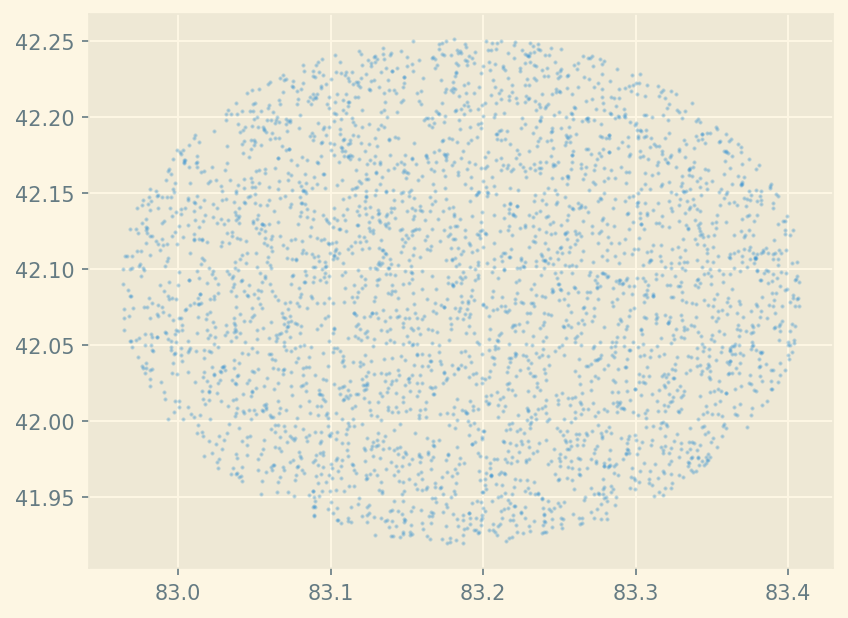

In [23]:
coindata = pd.read_csv('Data\\COIN-Gaia_13.csv')
 
plt.plot(coindata['ra'], coindata['dec'], 'o', markersize=1, alpha=0.25, linewidth = 0)




5


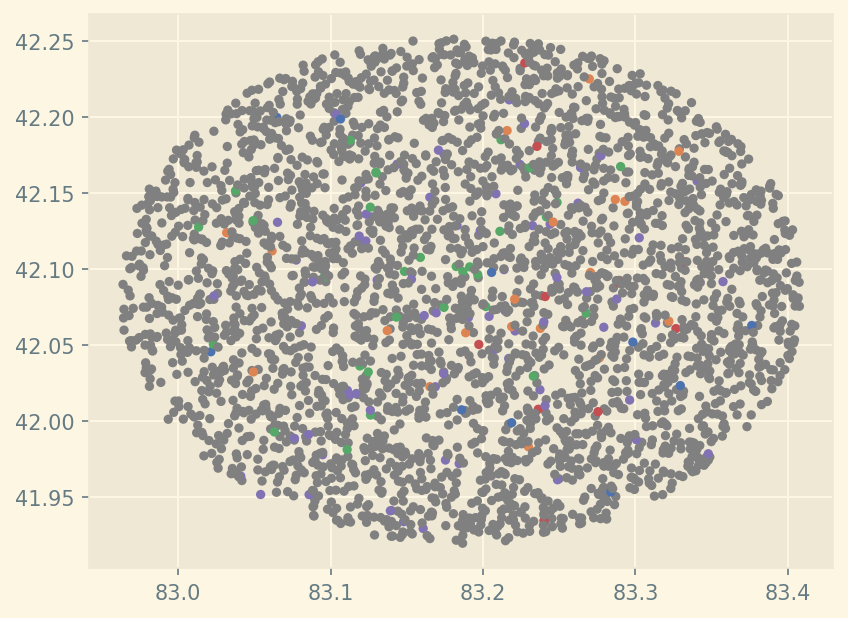

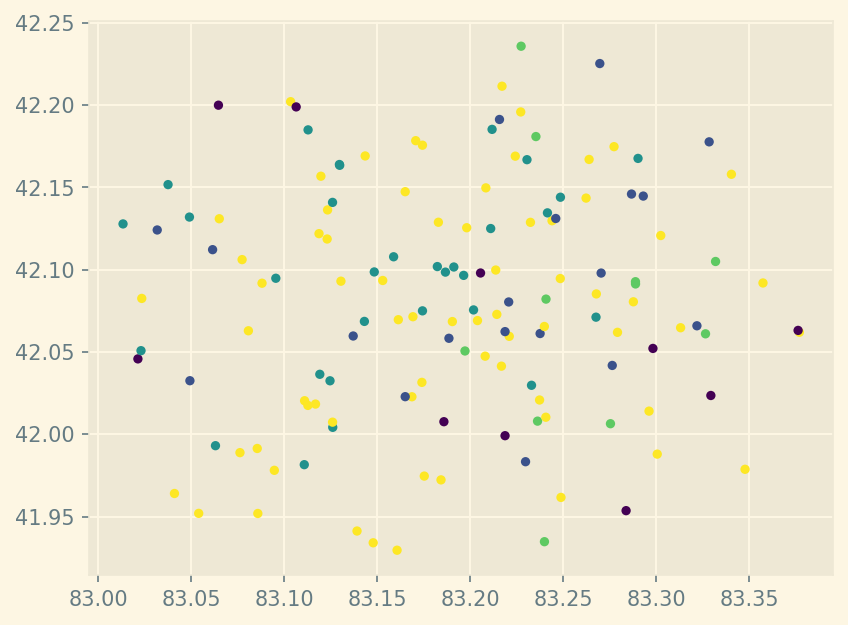

In [53]:
coinneeded = coindata[['ra', 'dec', 'parallax', 'pmra', 'pmdec']]
coinneeded = coinneeded.dropna()

coinclusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_method='leaf', min_samples=10).fit(coinneeded)

print(coinclusterer.labels_.max() + 1)

indices_to_keep = np.where(coinclusterer.labels_ != -1)[0]
filtered_df = coinneeded.iloc[indices_to_keep]


color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in coinclusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, coinclusterer.probabilities_)]
plt.scatter(coinneeded['ra'], coinneeded['dec'], s=20, linewidth=0, c=cluster_colors )
plt.show()

plt.scatter(filtered_df['ra'], filtered_df['dec'], s=20, linewidth=0, c=coinclusterer.labels_[indices_to_keep] )